In [1]:
import os
os.chdir(os.pardir)

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import matplotlib.patches as mpatches
import pandas as pd

import vapor
from vapor.models import Cambium

2020-10-27 13:45:59,592 [MainThread  ] [INFO ]  Starting log for vapor...


In [2]:
os.getcwd()

'/srv/data/home/skoebric/vapor-open'

In [3]:
# --- Load Regional Best ---
results = pd.read_pickle(os.path.join('results','bnef_results.pkl'))
results['scenario'] = 'Mid Cost'
results['batt_size'] = 0
results.rename({'geometry':'point', 'region':'pca'}, axis='columns', inplace=True)


In [42]:
region_map = pd.read_csv(os.path.join('data','geography','region_hierarchy.csv'))
region_map = region_map[['pca','rto','census_reg','inter']].drop_duplicates()

census_reg_dict = {
    'PA':'West',
    'MTN':'West',
    'ENC':'Midwest',
    'WNC':'Midwest',
    'WSC':'South',
    'MA':'Northeast',
    'NE':'Northeast',
    'ESC':'South',
    'SA':'South'
}
region_map['census_div'] = region_map['census_reg'].map(census_reg_dict)

df = results.merge(region_map, on='pca', how='left')


In [43]:
#CHECK THIS AFTER NEXT RUN
cs = [c for c in df.columns if 'cambium_grid_value_2' in c]
t = df[['cambium_grid_value_sum','lifetime_cambium_total_value','cambium_total_value_2020']]
t['sum'] = df[cs].sum(axis=1)
t

,cambium_grid_value_sum,lifetime_cambium_total_value,cambium_total_value_2020,sum
0,3213.391987,3.220295e+06,447.993553,2731.831169
1,3213.391987,3.220295e+06,447.993553,2731.831169
2,20582.563354,2.062747e+07,901.026609,19616.337295
3,12946.122053,1.302743e+07,979.125308,11876.672327
4,120080.444477,1.204821e+08,8392.370908,111527.542716
...,...,...,...,...
970,40602.564499,4.066222e+07,1261.886995,39212.500471
971,93129.118522,9.318094e+07,3051.448609,88697.118461
972,321565.469207,3.250240e+08,12515.854760,313329.770306
973,321565.469207,3.250240e+08,12515.854760,313329.770306


In [61]:
years = [str(i) for i in range(2014,2051,1)]
cambium_cols = [i for i in df.columns if 'cambium' in i]
cambium_cols = [i for i in cambium_cols if i[-4:] in years]


# --- subset cambium columns ---
c_df = df[cambium_cols + list(region_map.columns) + ['project_id','tech','system_capacity']]

# --- melt ---
c_df = c_df.melt(id_vars= list(region_map.columns) +['project_id','tech','system_capacity'])
c_df['year'] = [int(i[-4:]) for i in c_df['variable']]
c_df['variable'] = [str(i[:-5]) for i in c_df['variable']]

c_df['value_mw'] = c_df['value'] / c_df['system_capacity'] * 1000


In [125]:
variable_dict = {
    'cambium_co2_rate_avg':'CO2 Offset',
    'cambium_grid_value':'Grid Value',
#     'cambium_capacity_value':'Capacity Value',
}

value_col = 'value'
grouped = c_df.groupby(['census_div','tech','year','variable'], as_index=False)[['system_capacity',value_col]].sum()
grouped['census_div'] = pd.Categorical(grouped['census_div'], categories=['Northeast','West','Midwest','South'], ordered=True)
grouped.sort_values('census_div', inplace=True)

grouped = grouped.loc[grouped['year'] == 2020]
grouped = grouped.loc[grouped['variable'].isin(variable_dict.keys())]

pivot = grouped.pivot_table(
    index=['census_div','tech'],
    columns='variable',
    values='value'
)
pivot.reset_index(inplace=True)

sc = grouped[['census_div', 'tech', 'system_capacity']].drop_duplicates()

pivot = pivot.merge(sc, on=['tech','census_div'])

pivot['cambium_co2_rate_avg'] /= 2000
pivot['cambium_grid_value'] *= 1000 / 1e6
pivot['system_capacity'] /= 1000

pivot.to_csv(os.path.join('images','existing_impacts.csv'))
pivot

,census_div,tech,cambium_co2_rate_avg,cambium_grid_value,system_capacity
0,Northeast,pv,223.526863,82.020338,1424.3
1,Northeast,wind,68.893434,19.175714,209.2
2,West,pv,1232.092477,239.722218,4199.9
3,West,wind,281.640847,78.657293,1174.1
4,Midwest,pv,423.249999,56.448624,1032.4
5,Midwest,wind,4734.078863,682.916015,7071.6
6,South,pv,2638.956710,720.954885,11463.3
7,South,wind,2794.843737,1013.985006,9974.2


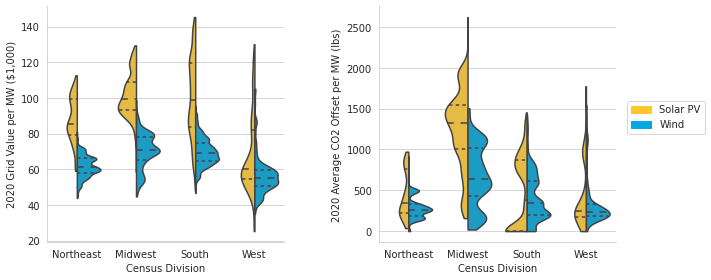

In [114]:
dist = c_df.copy()
# dist['census_div'] = pd.Categorical(dist['census_div'], categories=['Northeast','West','Midwest','South'], ordered=True)
# dist.sort_values('census_div', inplace=True)


dist = dist.loc[dist['variable'].isin(variable_dict.keys())]

sns.set_style('whitegrid')
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,4))

grid_value = dist.loc[dist['variable'] == 'cambium_grid_value']
co2 = dist.loc[dist['variable'] == 'cambium_co2_rate_avg']

sns.set_palette(sns.color_palette([vapor.tech_dict['pv'], vapor.tech_dict['wind']]))

sns.violinplot(
    data=grid_value, x='census_div', y='value_mw',
    hue='tech', split=True, inner='quart',
    ax=ax1, cut=0,
  )

sns.violinplot(
    data=co2, x='census_div', y='value_mw',
    hue='tech', split=True, inner='quart', 
    ax=ax2, cut=0,
  )

ax1.set_ylabel('2020 Grid Value per MW ($1,000)')
ax2.set_ylabel('2020 Average CO2 Offset per MW (lbs)')
ax1.set_xlabel('Census Division')
ax2.set_xlabel('Census Division')

ax1.legend([],[], frameon=False)
ax2.legend([],[], frameon=False)

label_dict = {'pv':'Solar PV', 'wind':'Wind'}
custom_patches = [mpatches.Patch(color=vapor.tech_dict[k], label=v) for k,v in label_dict.items()]
plt.legend(handles=custom_patches, bbox_to_anchor=(1.05, 0.6), loc=2, borderaxespad=0.)

plt.tight_layout()
plt.subplots_adjust(wspace=0.4)
sns.despine()

# g = sns.catplot(x='census_div', y='value_mw',
#                 hue='tech', col='variable',
#                data=dist, kind='violin', split=True, bw=.3,
#                height=5, aspect=1.2, sharey=False)


In [115]:
dist

,pca,rto,census_reg,inter,census_div,project_id,tech,system_capacity,variable,value,year,value_mw
17550,p122,rto12,MA,eastern,Northeast,607,wind,4500.0,cambium_co2_rate_avg,4378.018604,2020,972.893023
17551,p122,rto12,MA,eastern,Northeast,607,wind,4500.0,cambium_co2_rate_avg,4378.018604,2020,972.893023
17552,p82,rto6,ENC,eastern,Midwest,1502,wind,9000.0,cambium_co2_rate_avg,3270.047872,2020,363.338652
17553,p53,rto8,WNC,eastern,Midwest,2691,wind,10000.0,cambium_co2_rate_avg,16445.922836,2020,1644.592284
17554,p62,rto10,WSC,texas,South,4775,wind,90800.0,cambium_co2_rate_avg,29213.201226,2020,321.731291
...,...,...,...,...,...,...,...,...,...,...,...,...
170620,p103,rto6,ENC,eastern,Midwest,10000118,pv,23500.0,cambium_grid_value,1390.133161,2044,59.154603
170621,p131,rto18,NE,eastern,Northeast,10000122,pv,54600.0,cambium_grid_value,4432.221721,2044,81.176222
170622,p61,rto10,WSC,texas,South,10000123,pv,165000.0,cambium_grid_value,8236.109659,2044,49.915816
170623,p61,rto10,WSC,texas,South,10000124,pv,165000.0,cambium_grid_value,8236.109659,2044,49.915816


In [ ]:
df

In [ ]:
bars.pivot_table(index='census_div', columns='tech', values='value').plot.bar(stacked=True)

In [ ]:
# --- plot ---
g_df = c_df.groupby(['year','variable','tech'], as_index=False)['value'].sum()
g_df = g_df.loc[g_df['variable'] == 'cambium_total_value']
sns.lineplot(x='year', y='value', hue='tech', data=g_df)
